In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

import os
import mido
import pretty_midi as pm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

import tensorflow as tf
# import torch as pt
import joblib
import streamlit as st

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Things to check: 
- are all midi files being pulled 

In [26]:
def extract_basic_features(file_path):
    mid = mido.MidiFile(file_path)
    features = {
        'file_name': os.path.basename(file_path),
        'num_tracks': len(mid.tracks),
        'ticks_per_beat': mid.ticks_per_beat,
        'length': mid.length,
    }
    return features

def extract_pretty_midi_features(file_path):
    midi_data = pm.PrettyMIDI(file_path)
    features = {
        'num_notes': sum(len(instrument.notes) for instrument in midi_data.instruments),
        'note_density': sum(len(instrument.notes) for instrument in midi_data.instruments) / midi_data.get_end_time(),
        'avg_velocity': (sum(note.velocity for instrument in midi_data.instruments for note in instrument.notes) /
                         sum(len(instrument.notes) for instrument in midi_data.instruments)),
        'key_signature': None,
        'time_signature': None,
        'tempo': None
    }
    
    if midi_data.key_signature_changes:
        try:
            features['key_signature'] = midi_data.key_signature_changes[0].key_number
        except KeyError:
            features['key_signature'] = 'Unknown'
    
    if midi_data.time_signature_changes:
        features['time_signature'] = str(midi_data.time_signature_changes[0])
    
    if midi_data.get_tempo_changes()[1].size > 0:
        features['tempo'] = midi_data.get_tempo_changes()[1][0]
    
    return features

def get_composer_from_filename(file_path):
    return os.path.basename(file_path).split('_')[0]

def load_midi_files_to_dataframe(directory_path, composer):
    midi_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.mid')]
    data = []
    for file in midi_files:
        try:
            basic_features = extract_basic_features(file)
            pretty_midi_features = extract_pretty_midi_features(file)
            features = {**basic_features, **pretty_midi_features, 'composer': composer}
            data.append(features)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    df = pd.DataFrame(data)
    return df

# Specify the parent directory containing composer folders
parent_directory = 'C:\\Users\\gabri\\OneDrive\\Desktop\\MSAAI\\AAI-511\\aai-511_group1\\midiclassics'

# List of composers (folder names)
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Dictionary to hold DataFrames for each composer
composer_dataframes = {}

# Process each composer's folder
for composer in composers:
    composer_folder = os.path.join(parent_directory, composer)
    composer_df = load_midi_files_to_dataframe(composer_folder, composer)
    composer_dataframes[composer] = composer_df
    print(f"{composer} DataFrame:")
    print(composer_df.head())

# Merge all DataFrames into a single DataFrame
all_composers_df = pd.concat(composer_dataframes.values(), ignore_index=True)

# Display the merged DataFrame
print("Merged DataFrame:")
print(all_composers_df.head())

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Bach DataFrame:
      file_name  num_tracks  ticks_per_beat     length  num_notes  \
0  003706b_.mid           5            1024  46.956456        304   
1  003806b_.mid           5            1024  45.000610        253   
2  003907bv.mid           5            1024  42.500610        285   
3  003907b_.mid           5            1024  42.500610        285   
4  004003b_.mid           5            1024  30.000000        204   

   note_density  avg_velocity  key_signature       time_signature      tempo  \
0      6.474083          96.0            9.0  4/4 at 0.00 seconds  92.000129   
1      5.622222          96.0           21.0  4/4 at 0.00 seconds  96.000000   
2      6.705882          96.0            7.0  4/4 at 0.00 seconds  96.000000   
3      6.705882          96.0           10.0  4/4 at 0.00 seconds  96.000000   
4      6.800000          96.0           19.0  4/4 at 0.00 seconds  96.000000   

  composer  
0     Bach  
1     Bach  
2     Bach  
3     Bach  
4     Bach  
Error proc

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Beethoven DataFrame:
                      file_name  num_tracks  ticks_per_beat      length  \
0  32 Variations on a theme.mid           4             480  618.942806   
1        Andante in F Major.mid           3             192  250.500000   
2               Anh06 Rondo.mid           4             120  336.875269   
3  Anh08Nb1 Gavotte 4 hands.mid           6             120  167.176113   
4       Bagatella Fur Elise.mid           7             120  131.096678   

   num_notes  note_density  avg_velocity  key_signature       time_signature  \
0       7318     11.823386     69.349412            0.0  3/4 at 0.00 seconds   
1       4323     17.257485     52.873236            5.0  3/8 at 0.00 seconds   
2       4438     13.174015     77.954484           10.0  6/8 at 0.00 seconds   
3       1571      9.397276     63.513686            5.0  4/4 at 0.00 seconds   
4        950      7.246560     81.637895            0.0  3/4 at 0.00 seconds   

        tempo   composer  
0  120.000000  Beeth

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Chopin DataFrame:
                                           file_name  num_tracks  \
0   (2542)Prelude opus.28, No.16 in B flat minor.mid           2   
1  19 Polish Songs, for Solo Voice and Piano acco...           3   
2  19 Polish Songs, for Solo Voice and Piano acco...           3   
3  19 Polish Songs, for Solo Voice and Piano acco...           3   
4  19 Polish Songs, for Solo Voice and Piano acco...           3   

   ticks_per_beat      length  num_notes  note_density  avg_velocity  \
0            1024   64.000262       1199     18.734394     63.552961   
1             480  108.675018       1742     16.142204     97.889782   
2             480   58.162016        669     11.527386     87.372197   
3             480  122.586853        682      5.587330    100.079179   
4             480  241.889534       1062      4.391190    100.000000   

   key_signature       time_signature       tempo composer  
0           22.0  6/4 at 0.00 seconds  180.000180   Chopin  
1            NaN  

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing file C:\Users\gabri\OneDrive\Desktop\MSAAI\AAI-511\aai-511_group1\midiclassics\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Mozart DataFrame:
                           file_name  num_tracks  ticks_per_beat      length  \
0        A piece for Piano,K.176.mid           4             240  116.503280   
1               Adagio in B flat.mid           6             480  716.505484   
2  Another piece for Piano,K.176.mid           4             240  128.892212   
3                 Contradance n1.mid           3             120   34.904511   
4                 Contradance n2.mid           3             120   59.256950   

   num_notes  note_density  avg_velocity  key_signature       time_signature  \
0        881      7.577629     64.000000            NaN  3/4 at 0.00 seconds   
1       3332      4.650348     81.130552            2.0  4/4 at 0.00 seconds   
2       1139      8.836841     64.000000            NaN  3/4 at 0.00 seconds   
3

In [27]:
all_composers_df.head()

,file_name,num_tracks,ticks_per_beat,length,num_notes,note_density,avg_velocity,key_signature,time_signature,tempo,composer
0,003706b_.mid,5,1024,46.956456,304,6.474083,96.0,9.0,4/4 at 0.00 seconds,92.000129,Bach
1,003806b_.mid,5,1024,45.000610,253,5.622222,96.0,21.0,4/4 at 0.00 seconds,96.000000,Bach
2,003907bv.mid,5,1024,42.500610,285,6.705882,96.0,7.0,4/4 at 0.00 seconds,96.000000,Bach
3,003907b_.mid,5,1024,42.500610,285,6.705882,96.0,10.0,4/4 at 0.00 seconds,96.000000,Bach
4,004003b_.mid,5,1024,30.000000,204,6.800000,96.0,19.0,4/4 at 0.00 seconds,96.000000,Bach


In [28]:
all_composers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       1522 non-null   object 
 1   num_tracks      1522 non-null   int64  
 2   ticks_per_beat  1522 non-null   int64  
 3   length          1522 non-null   float64
 4   num_notes       1522 non-null   int64  
 5   note_density    1522 non-null   float64
 6   avg_velocity    1522 non-null   float64
 7   key_signature   1262 non-null   float64
 8   time_signature  1520 non-null   object 
 9   tempo           1522 non-null   float64
 10  composer        1522 non-null   object 
dtypes: float64(5), int64(3), object(3)
memory usage: 130.9+ KB


In [29]:
all_composers_df = all_composers_df.dropna()

In [30]:
all_composers_df.drop(columns='file_name', inplace=True)

In [31]:
all_composers_df.reset_index(drop=True, inplace=True)

In [32]:
all_composers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_tracks      1262 non-null   int64  
 1   ticks_per_beat  1262 non-null   int64  
 2   length          1262 non-null   float64
 3   num_notes       1262 non-null   int64  
 4   note_density    1262 non-null   float64
 5   avg_velocity    1262 non-null   float64
 6   key_signature   1262 non-null   float64
 7   time_signature  1262 non-null   object 
 8   tempo           1262 non-null   float64
 9   composer        1262 non-null   object 
dtypes: float64(5), int64(3), object(2)
memory usage: 98.7+ KB


In [33]:
all_composers_df.head()

,num_tracks,ticks_per_beat,length,num_notes,note_density,avg_velocity,key_signature,time_signature,tempo,composer
0,5,1024,46.956456,304,6.474083,96.0,9.0,4/4 at 0.00 seconds,92.000129,Bach
1,5,1024,45.000610,253,5.622222,96.0,21.0,4/4 at 0.00 seconds,96.000000,Bach
2,5,1024,42.500610,285,6.705882,96.0,7.0,4/4 at 0.00 seconds,96.000000,Bach
3,5,1024,42.500610,285,6.705882,96.0,10.0,4/4 at 0.00 seconds,96.000000,Bach
4,5,1024,30.000000,204,6.800000,96.0,19.0,4/4 at 0.00 seconds,96.000000,Bach


In [34]:
all_composers_df['composer'].value_counts()

composer
Bach         777
Mozart       196
Beethoven    189
Chopin       100
Name: count, dtype: int64

Features and target assignment, encoding, Scaling, and reshaping data. 

In [35]:
features = all_composers_df.drop(columns='composer')
target = all_composers_df['composer']

In [36]:
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = features.select_dtypes(include=['object']).columns.tolist()

In [37]:
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(target)

In [38]:
column_transformer = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('categorical', OneHotEncoder(), categorical_features)
    ]
)

In [39]:
transformed_features = column_transformer.fit_transform(features)

In [40]:
dense_transformed_features = transformed_features.toarray()

In [41]:
reshaped_features = dense_transformed_features.reshape(dense_transformed_features.shape[0], 1, dense_transformed_features.shape[1])

In [42]:
random_state = 88

In [43]:
features_train, features_test, target_train, target_test = train_test_split(reshaped_features, encoded_target, test_size=0.3, random_state=random_state )

Model Architecture

In [51]:
model = Sequential()

In [52]:
model.add(LSTM(50, activation='relu', input_shape=(1, dense_transformed_features.shape[1])))
model.add(Dropout(0.2))

# Add dense layers
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(encoded_target)), activation='softmax'))

In [53]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                16800     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 404       
                                                                 
Total params: 22,304
Trainable params: 22,304
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(features_train, target_train, epochs=70, batch_size=32, validation_data=(features_test, target_test))

Epoch 1/70
28/28 [==============================] - 1s 9ms/step - loss: 1.2514 - accuracy: 0.6036 - val_loss: 1.1155 - val_accuracy: 0.5937
Epoch 2/70
28/28 [==============================] - 0s 2ms/step - loss: 0.9246 - accuracy: 0.6331 - val_loss: 0.8197 - val_accuracy: 0.6042
Epoch 3/70
28/28 [==============================] - 0s 2ms/step - loss: 0.7383 - accuracy: 0.6614 - val_loss: 0.7382 - val_accuracy: 0.6649
Epoch 4/70
28/28 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.6931 - val_loss: 0.7019 - val_accuracy: 0.6966
Epoch 5/70
28/28 [==============================] - 0s 2ms/step - loss: 0.6607 - accuracy: 0.6818 - val_loss: 0.6803 - val_accuracy: 0.7230
Epoch 6/70
28/28 [==============================] - 0s 2ms/step - loss: 0.6401 - accuracy: 0.7078 - val_loss: 0.6625 - val_accuracy: 0.7414
Epoch 7/70
28/28 [==============================] - 0s 2ms/step - loss: 0.6239 - accuracy: 0.7282 - val_loss: 0.6459 - val_accuracy: 0.7388
Epoch 8/70
28/28 [==

In [56]:
loss, accuracy = model.evaluate(features_test, target_test)
print(f'Test Accuracy: {accuracy:.4f}')

12/12 [==============================] - 0s 1ms/step - loss: 0.6044 - accuracy: 0.7968
Test Accuracy: 0.7968


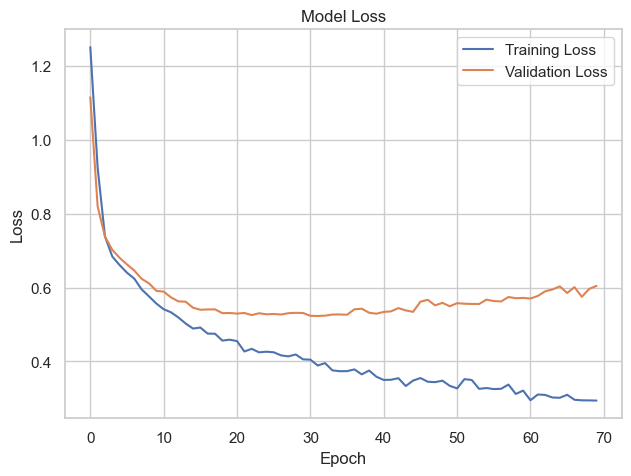

In [57]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Working on dashboard: 

In [141]:
joblib.dump(model, 'draft_lstm.pkl')

joblib.dump(column_transformer, 'column_transfomer.pkl')

INFO:tensorflow:Assets written to: ram://cf1854f2-ebe0-477e-ad42-152b23048b79/assets


['column_transfomer.pkl']

In [ ]:
modelo = load_model('draft_lstm.h5')